In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set random seeds for reproducibility
tf.random.set_seed(1)
np.random.seed(1)


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

MessageError: ignored

In [ ]:
artists = pd.read_csv('/content/artists (1).csv')
artists = artists.sort_values(by=['paintings'], ascending=False)


In [ ]:
# Create a dataframe with artists having more than 200 paintings
artists_top = artists[artists['paintings'] >= 329].reset_index()
artists_top = artists_top[['name', 'paintings']]
artists_top['class_weight'] = artists_top.paintings.sum() / (artists_top.shape[0] * artists_top.paintings)
print(artists_top)


                    name  paintings  class_weight
0       Vincent van Gogh        877      0.671038
1            Edgar Degas        702      0.838319
2          Pablo Picasso        439      1.340547
3  Pierre-Auguste Renoir        336      1.751488


In [ ]:
  class_weights = artists_top['class_weight'].to_dict()


In [ ]:
images_dir = '/content/drive/MyDrive/mini_project/Dataset/dataset'
artists_top_name = artists_top['name'].str.replace(' ', '_').values

# Check if all directories exist
for name in artists_top_name:
    if not os.path.exists(os.path.join(images_dir, name)):
        print("Did not find -->", os.path.join(images_dir, name))


In [ ]:
# Data augmentation
batch_size = 16
train_input_shape = (224, 224, 3)
n_classes = artists_top.shape[0]

train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

valid_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )


Found 1885 images belonging to 4 classes.
Found 469 images belonging to 4 classes.


In [ ]:
# Model
base_model = keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=train_input_shape)

for layer in base_model.layers:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(n_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

optimizer = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

n_epochs = 15

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
# Learning rate schedule
def lr_schedule(epoch):
    if epoch < 10:
        return 0.0001
    else:
        return 0.0001 * tf.math.exp(0.1 * (10 - epoch))

lr_scheduler = LearningRateScheduler(lr_schedule)

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1,
                           restore_best_weights=True)

history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    validation_data=valid_generator,
                    validation_steps=len(valid_generator),
                    epochs=n_epochs,
                    callbacks=[lr_scheduler, early_stop],
                    class_weight=class_weights
                   )


Epoch 1/15
118/118 [==============================] - 469s 3s/step - loss: 1.1711 - accuracy: 0.5910 - val_loss: 3.1829 - val_accuracy: 0.2985 - lr: 1.0000e-04
Epoch 2/15
118/118 [==============================] - 61s 514ms/step - loss: 0.7154 - accuracy: 0.7438 - val_loss: 2.8042 - val_accuracy: 0.1855 - lr: 1.0000e-04
Epoch 3/15
118/118 [==============================] - 59s 503ms/step - loss: 0.6034 - accuracy: 0.7942 - val_loss: 2.8729 - val_accuracy: 0.3731 - lr: 1.0000e-04
Epoch 4/15
118/118 [==============================] - 59s 502ms/step - loss: 0.4761 - accuracy: 0.8387 - val_loss: 4.7514 - val_accuracy: 0.2985 - lr: 1.0000e-04
Epoch 5/15
118/118 [==============================] - 59s 502ms/step - loss: 0.4691 - accuracy: 0.8313 - val_loss: 3.7048 - val_accuracy: 0.3198 - lr: 1.0000e-04
Epoch 6/15
118/118 [==============================] - 60s 505ms/step - loss: 0.4201 - accuracy: 0.8403 - val_loss: 1.9262 - val_accuracy: 0.5629 - lr: 1.0000e-04
Epoch 7/15
118/118 [==========

In [ ]:
# Loading the model
model_path = 'D:/miniproject/model.h5'
loaded_model = keras.models.load_model(model_path)

In [ ]:
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

print("Train Accuracy:", final_train_accuracy)
print("Validation Accuracy:", final_val_accuracy)


Train Accuracy: 0.9358090162277222
Validation Accuracy: 0.8742004036903381


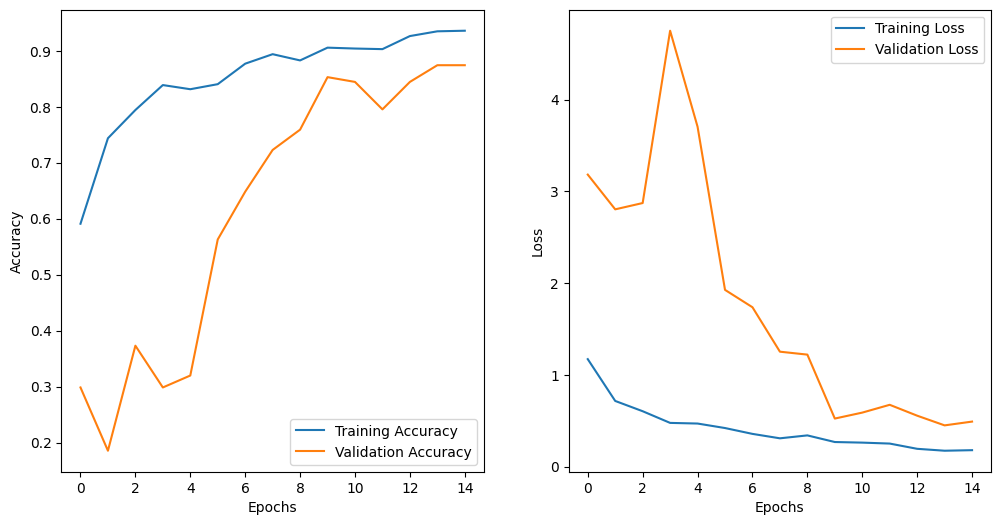

In [ ]:
# Plot training history
def plot_training(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training(history)


In [ ]:
# Classification report
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def showClassificationReportGenerator(model, valid_generator):
    y_true = valid_generator.classes
    y_pred = model.predict(valid_generator)
    y_pred = np.argmax(y_pred, axis=1)

    print('Classification Report:')
    print(classification_report(y_true, y_pred, target_names=artists_top_name.tolist()))

showClassificationReportGenerator(model, valid_generator)


30/30 [==============================] - 15s 365ms/step
Classification Report:
                       precision    recall  f1-score   support

     Vincent_van_Gogh       0.40      0.42      0.41       175
          Edgar_Degas       0.30      0.30      0.30       140
        Pablo_Picasso       0.14      0.11      0.13        87
Pierre-Auguste_Renoir       0.12      0.13      0.13        67

             accuracy                           0.29       469
            macro avg       0.24      0.24      0.24       469
         weighted avg       0.28      0.29      0.29       469



1/1 [==============================] - 0s 24ms/step


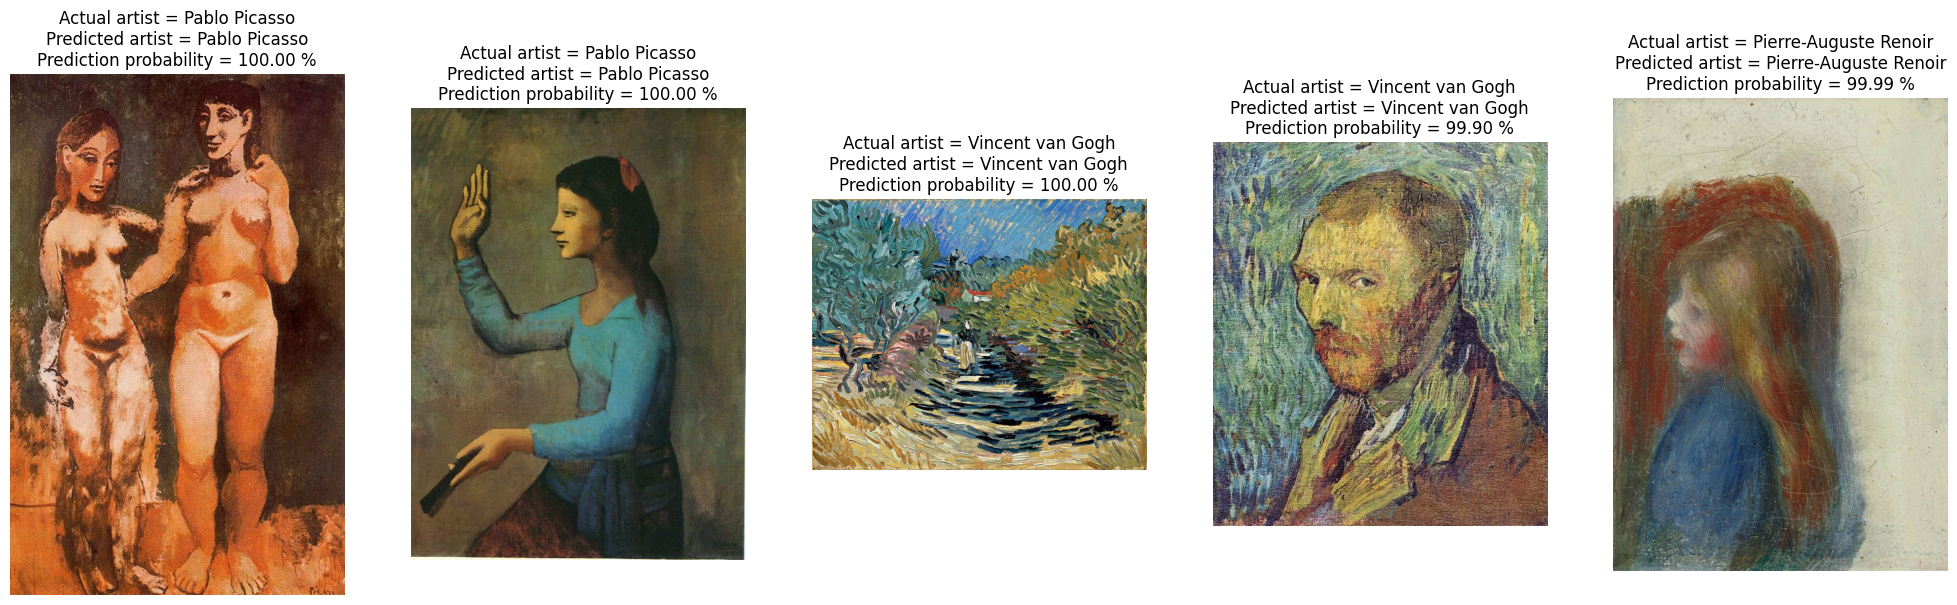

In [ ]:
# Example predictions
n = 5
fig, axes = plt.subplots(1, n, figsize=(25, 10))

for i in range(n):
    random_artist = random.choice(artists_top_name)
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
    random_image_file = os.path.join(images_dir, random_artist, random_image)

    test_image = keras.preprocessing.image.load_img(random_image_file, target_size=(train_input_shape[0], train_input_shape[1]))
    test_image = keras.preprocessing.image.img_to_array(test_image)
    test_image /= 255.0
    test_image = np.expand_dims(test_image, axis=0)

    prediction = model.predict(test_image)
    prediction_probability = np.amax(prediction)
    prediction_idx = np.argmax(prediction)
    labels = train_generator.class_indices
    labels = dict((v, k) for k, v in labels.items())

    title = "Actual artist = {}\nPredicted artist = {}\nPrediction probability = {:.2f} %" \
                .format(random_artist.replace('_', ' '), labels[prediction_idx].replace('_', ' '),
                        prediction_probability * 100)

    axes[i].imshow(plt.imread(random_image_file))
    axes[i].set_title(title)
    axes[i].axis('off')

plt.show()

30/30 [==============================] - 11s 355ms/step


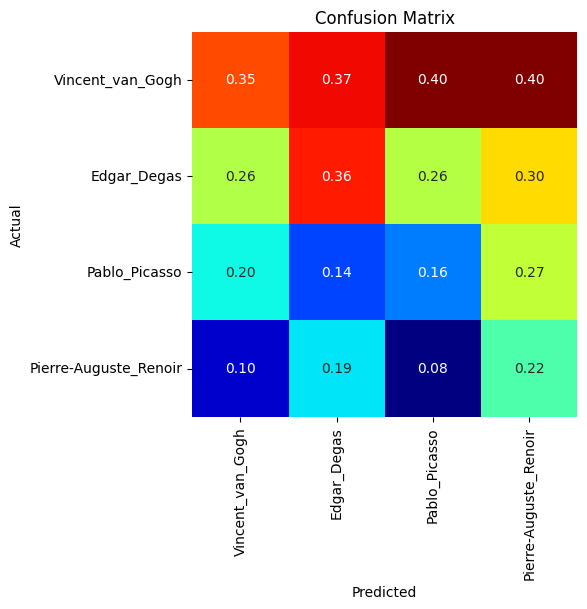

Classification Report:
                       precision    recall  f1-score   support

     Vincent_van_Gogh       0.38      0.35      0.36       175
          Edgar_Degas       0.34      0.36      0.35       140
        Pablo_Picasso       0.18      0.16      0.17        87
Pierre-Auguste_Renoir       0.19      0.22      0.20        67

             accuracy                           0.30       469
            macro avg       0.27      0.27      0.27       469
         weighted avg       0.30      0.30      0.30       469



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def showClassificationReportGenerator(model, valid_generator, STEP_SIZE_VALID, tick_labels):
    # Define the number of classes
    n_classes = len(tick_labels)

    y_true = valid_generator.classes
    y_pred = model.predict(valid_generator)
    y_pred = np.argmax(y_pred, axis=1)

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
    conf_matrix = conf_matrix / np.sum(conf_matrix, axis=1)

    fig, ax = plt.subplots(figsize=(5, 5))
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False,
                cmap="jet", xticklabels=tick_labels, yticklabels=tick_labels, ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix')
    plt.show()

    print('Classification Report:')
    report = classification_report(y_true, y_pred, target_names=tick_labels)
    print(report)

# Define STEP_SIZE_VALID based on the length of your valid_generator
STEP_SIZE_VALID = len(valid_generator)

# Replace tick_labels with your list of class labels (e.g., artists_top_name)
tick_labels = artists_top_name

showClassificationReportGenerator(model, valid_generator, STEP_SIZE_VALID, tick_labels)
